# Step 0: Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. 

In [ ]:
'''
Loading libraries
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

from time import time
import matplotlib.pyplot as plt
import pickle

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import nltk
nltk.download('wordnet')

# Step 1: Load the dataset

The dataset we'll use is a list of over one million news headlines published over a period of 15 years. We'll start by loading it from the `abcnews-date-text.csv` file.

In [1]:
'''
Load the dataset from the CSV and save it to 'data_text'
'''
import pandas as pd
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);

# We only need the Headlines text column from the data
data_text = data[:300000][['headline_text']];
data_text['index'] = data_text.index

documents = data_text

Let's glance at the dataset:

In [2]:
'''
Get the total number of documents
'''
print(len(documents))

300000


In [3]:
documents[:5]

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


# Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [6]:
# past tense to present tense
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) 

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [7]:
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [17]:
'''
Perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return ' '.join(result)

In [19]:
'''
Preview a document after preprocessing
'''
document_num = 4310
doc_sample = documents[documents['index'] == document_num].values[0][0]

print("Original document: ")
print(doc_sample)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
rain helps dampen bushfires


Tokenized and lemmatized document: 
rain help dampen bushfir


In [20]:
documents

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4
...,...,...
299995,broughton hall audit reveals serious breaches,299995
299996,broughton hall fails key standards,299996
299997,broughton hall safe for residents govt says,299997
299998,burn off at conservation park aims to prevent,299998


Let's now preprocess all the news headlines we have. To do that, let's use the [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function from pandas to apply `preprocess()` to the `headline_text` column

**Note**: This may take a few minutes.

In [21]:
# preprocess all the headlines, saving the list of results as 'processed_docs'
processed_docs = documents.headline_text.map(preprocess)

In [22]:
'''
Preview 'processed_docs'
'''
processed_docs[:10]

0          decid communiti broadcast licenc
1                            wit awar defam
2         call infrastructur protect summit
3                    staff aust strike rise
4           strike affect australian travel
5              ambiti olsson win tripl jump
6          antic delight record break barca
7    aussi qualifi stosur wast memphi match
8           aust address secur council iraq
9                      australia lock timet
Name: headline_text, dtype: object

# Step 3: Preparing Data

## Step 3.1: Bag of words on the dataset

In [27]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

bow_data = tf_vectorizer.fit_transform(processed_docs)

<!-- I found that my topics almost all had global warming or climate change at the top of the list. This could indicate that we should add these words to our stopwords like since they don’t tell us anything we didn’t already know. We already knew that the dataset was tweets about climate change.

This result also may have come from the fact that tweets are very short and this particular method, LDA (which works very well for longer text documents), does not work well on shorter text documents like tweets. In the bonus section to follow I suggest replacing the LDA model with an NMF model and try creating a new set of topics. In my own experiments I found that NMF generated better topics from the tweets than LDA did, even without removing ‘climate change’ and ‘global warming’ from the tweets. -->

## Step 3.2: TF-IDF on our dataset ##

While performing TF-IDF on the corpus is not necessary for LDA implemention using the gensim model, it is recemmended. TF-IDF expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality.

*Please note: The author of Gensim dictates the standard procedure for LDA to be using the Bag of Words model.*

**TF-IDF stands for "Term Frequency, Inverse Document Frequency".**

* It is a way to score the importance of words (or "terms") in a document based on how frequently they appear across multiple documents.
* If a word appears frequently in a document, it's important. Give the word a high score. But if a word appears in many documents, it's not a unique identifier. Give the word a low score.
* Therefore, common words like "the" and "for", which appear in many documents, will be scaled down. Words that appear frequently in a single document will be scaled up.

In other words:

* TF(w) = `(Number of times term w appears in a document) / (Total number of terms in the document)`.
* IDF(w) = `log_e(Total number of documents / Number of documents with term w in it)`.

**For example**

* Consider a document containing `100` words wherein the word 'tiger' appears 3 times. 
* The term frequency (i.e., tf) for 'tiger' is then: 
    - `TF = (3 / 100) = 0.03`. 

* Now, assume we have `10 million` documents and the word 'tiger' appears in `1000` of these. Then, the inverse document frequency (i.e., idf) is calculated as:
    - `IDF = log(10,000,000 / 1,000) = 4`. 

* Thus, the Tf-idf weight is the product of these quantities: 
    - `TF-IDF = 0.03 * 4 = 0.12`.

In [54]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

tfidf_data = tfidf_vectorizer.fit_transform(processed_docs)

# Step 4: Run LDA and Visualize results

In [45]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Step 4.1: Running LDA using Bag of Words ##

In [47]:
lda_bow = LatentDirichletAllocation(n_components=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=10)
lda_bow.fit(bow_data)

In [58]:
# # saving the model
# with open('lda_bow.pickle', 'wb') as f:
#     pickle.dump(lda_bow, f)

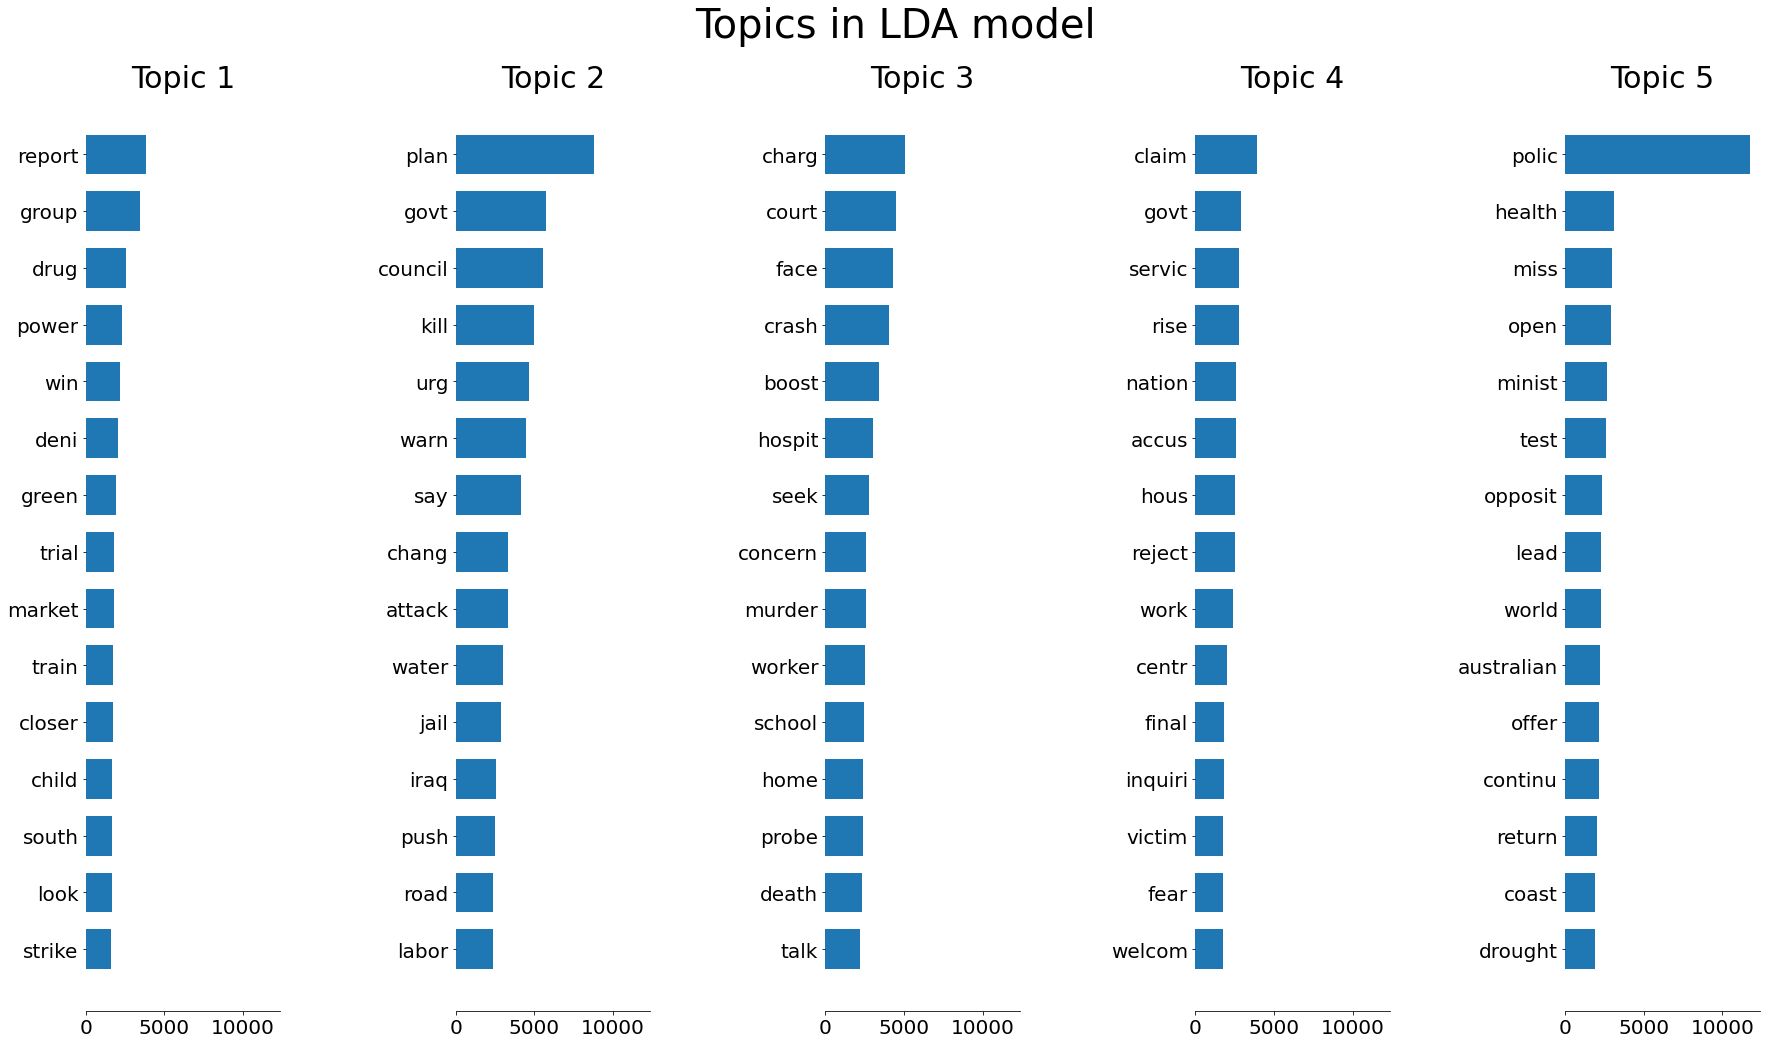

In [51]:
n_top_words = 15
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda_bow, tf_feature_names, n_top_words, 'Topics in LDA model')

### Classification of the topics ###

Based on the words associated with the topics, we can give some meaningful names to the Topics (although in our project it's very hard to come up with some names 😐)
* 1: 
* 2: 
* 3: 
* 4: 
* 5:  

## Step 4.2 Running LDA using TF-IDF ##

In [55]:
lda_tfidf = LatentDirichletAllocation(n_components=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=10)
lda_tfidf.fit(tfidf_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=5, random_state=10)

In [59]:
# # saving the model
# with open('lda_tfidf.pickle', 'wb') as f:
#     pickle.dump(lda_tfidf, f)

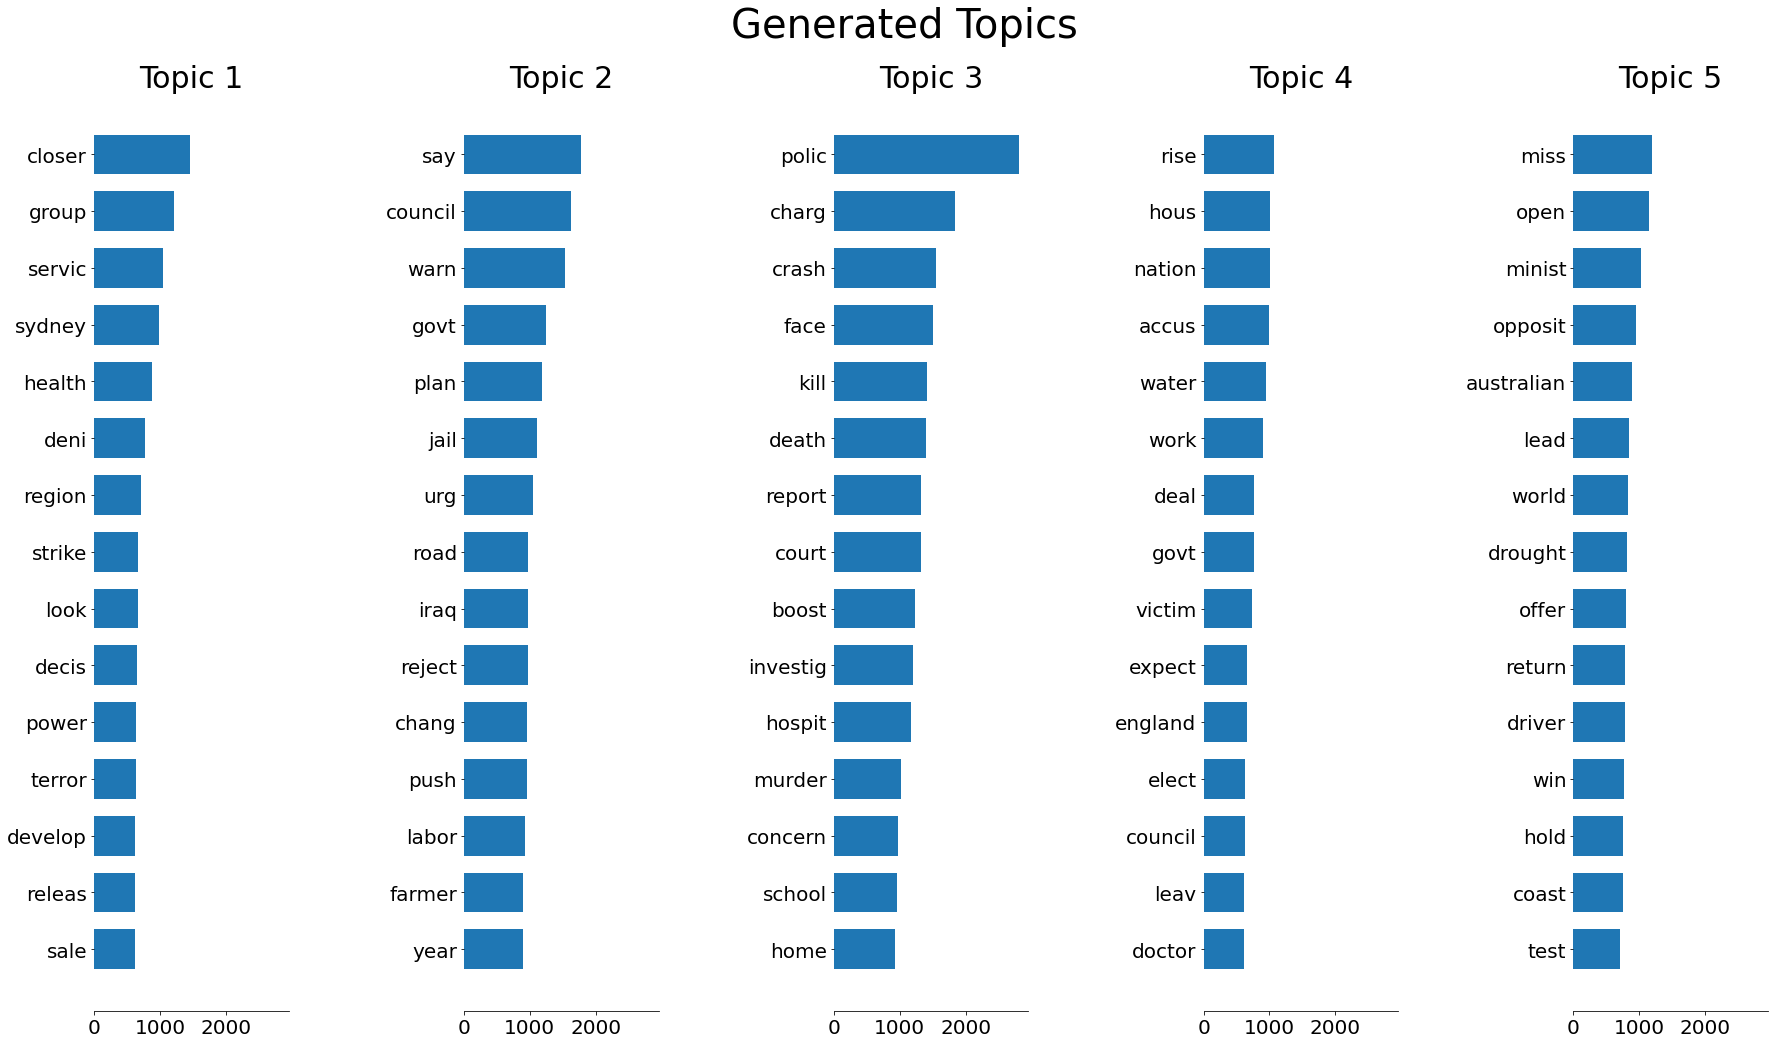

In [57]:
n_top_words = 15
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

plot_top_words(lda_tfidf, tfidf_feature_names, n_top_words, 'Generated Topics')

### Classification of the topics ###

As we can see, when using tf-idf, heavier weights are given to words that are not as frequent which results in nouns being factored in. That makes it harder to figure out the categories as nouns can be hard to categorize. This goes to show that the models we apply depend on the type of corpus of text we are dealing with. 


# Step 5: Testing on unseen document
We will check to see where our test document would be classified. 

In [118]:
unseen_document = "My favorite sports activities are cycling and swimming."

In [115]:
def predict_topic(sentence, vectorizer, model):
    result = model.transform(vectorizer.transform([sentence]))
    topic = np.argmax(result) + 1
    print('The document: "{}"\nbelongs to topic {} with {:.2f}% probability'.format(sentence, str(topic), result[0][topic-1]*100))
    return topic

## Step 5.1: using LDA BoW model

In [119]:
result = predict_topic(preprocess(unseen_document), tf_vectorizer, lda_bow)

The document: "favorit sport activ cycl swim"
belongs to topic 2 with 36.74% probability


## Step 5.2: using LDA TF-IDF model

In [120]:
result = predict_topic(preprocess(unseen_document), tfidf_vectorizer, lda_tfidf)

The document: "favorit sport activ cycl swim"
belongs to topic 5 with 38.00% probability
